In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import CatBoostClassifier 

In [2]:
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['fatality']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['fatality']
xtrain_smote = pd.read_parquet("../data/xtrain_smote.parquet")
ytrain_smote = pd.read_parquet("../data/ytrain_smote.parquet")['fatality']

In [4]:
clf = CatBoostClassifier(random_state=0, task_type="GPU")
clf.fit(xtrain, ytrain, plot=True, eval_set=(xtest, ytest))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.036017
0:	learn: 0.6159795	test: 0.6160314	best: 0.6160314 (0)	total: 253ms	remaining: 4m 12s
1:	learn: 0.5486772	test: 0.5487770	best: 0.5487770 (1)	total: 433ms	remaining: 3m 35s
2:	learn: 0.4908710	test: 0.4910118	best: 0.4910118 (2)	total: 614ms	remaining: 3m 24s
3:	learn: 0.4399656	test: 0.4401467	best: 0.4401467 (3)	total: 794ms	remaining: 3m 17s
4:	learn: 0.3938944	test: 0.3941122	best: 0.3941122 (4)	total: 979ms	remaining: 3m 14s
5:	learn: 0.3544751	test: 0.3547342	best: 0.3547342 (5)	total: 1.16s	remaining: 3m 12s
6:	learn: 0.3207768	test: 0.3210704	best: 0.3210704 (6)	total: 1.35s	remaining: 3m 11s
7:	learn: 0.2913898	test: 0.2917192	best: 0.2917192 (7)	total: 1.54s	remaining: 3m 10s
8:	learn: 0.2651514	test: 0.2655178	best: 0.2655178 (8)	total: 1.73s	remaining: 3m 10s
9:	learn: 0.2429130	test: 0.2433080	best: 0.2433080 (9)	total: 1.92s	remaining: 3m 10s
10:	learn: 0.2228261	test: 0.2232494	best: 0.2232494 (10)	total: 2.12s	remaining: 3m 10s
11:	learn: 

In [7]:
with open('../models/CatBoost.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [3]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/CatBoost.pickle', 'rb') as f:
    clf = pickle.load(f)

In [6]:
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)

In [7]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

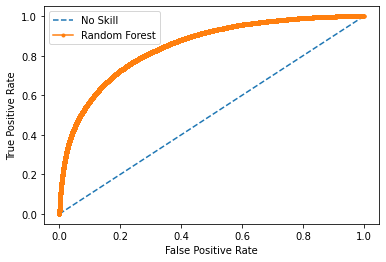

Best Threshold=0.014981, G-Mean=0.763


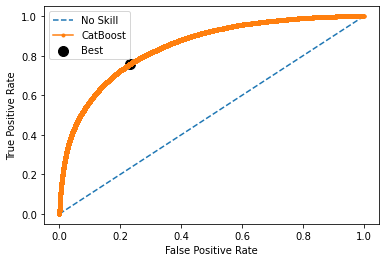

ROC-AUC score of the model: 0.8475000636086781
Accuracy of the model: 0.7691548832620848

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    997197
           1       0.05      0.76      0.09     15456

    accuracy                           0.77   1012653
   macro avg       0.52      0.76      0.48   1012653
weighted avg       0.98      0.77      0.86   1012653


Confusion matrix: 
[[767177 230020]
 [  3746  11710]]



AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

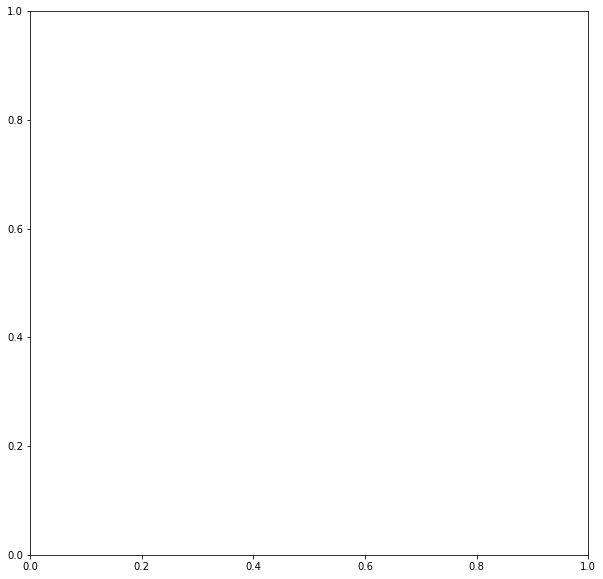

In [8]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='CatBoost')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred_new_threshold,
                                 cmap=plt.cm.Greens,
                                 normalize=normalize,
                                 ax = ax)
    ax.set_title(title)

# CatBoost con SMOTE

In [9]:
clf = CatBoostClassifier(random_state=0, task_type="GPU")
clf.fit(xtrain_smote, ytrain_smote, plot=True, eval_set=(xtest, ytest))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.035046
0:	learn: 0.6623714	test: 0.6555206	best: 0.6555206 (0)	total: 257ms	remaining: 4m 16s
1:	learn: 0.6245840	test: 0.6225964	best: 0.6225964 (1)	total: 522ms	remaining: 4m 20s
2:	learn: 0.5991217	test: 0.5908910	best: 0.5908910 (2)	total: 783ms	remaining: 4m 20s
3:	learn: 0.5705806	test: 0.5542982	best: 0.5542982 (3)	total: 1.05s	remaining: 4m 20s
4:	learn: 0.5490996	test: 0.5273886	best: 0.5273886 (4)	total: 1.33s	remaining: 4m 24s
5:	learn: 0.5278857	test: 0.5033843	best: 0.5033843 (5)	total: 1.62s	remaining: 4m 28s
6:	learn: 0.5024264	test: 0.4824473	best: 0.4824473 (6)	total: 1.88s	remaining: 4m 27s
7:	learn: 0.4832311	test: 0.4573833	best: 0.4573833 (7)	total: 2.16s	remaining: 4m 27s
8:	learn: 0.4671943	test: 0.4399269	best: 0.4399269 (8)	total: 2.42s	remaining: 4m 26s
9:	learn: 0.4496908	test: 0.4173293	best: 0.4173293 (9)	total: 2.69s	remaining: 4m 26s
10:	learn: 0.4292340	test: 0.4028015	best: 0.4028015 (10)	total: 2.95s	remaining: 4m 25s
11:	learn: 

In [10]:
with open('../models/LightGBM_smote.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [11]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/LightGBM_smote.pickle', 'rb') as f:
    clf = pickle.load(f)

In [12]:
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)

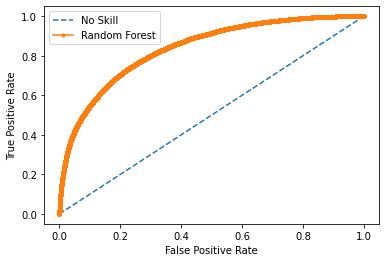

Best Threshold=0.022081, G-Mean=0.754


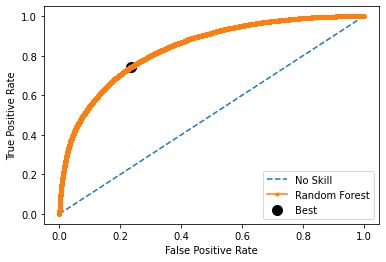

ROC-AUC score of the model: 0.8378811375054463
Accuracy of the model: 0.7652285629924565

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.77      0.87    997197
           1       0.05      0.74      0.09     15456

    accuracy                           0.77   1012653
   macro avg       0.52      0.75      0.48   1012653
weighted avg       0.98      0.77      0.85   1012653


Confusion matrix: 
[[763433 233764]
 [  3978  11478]]



AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

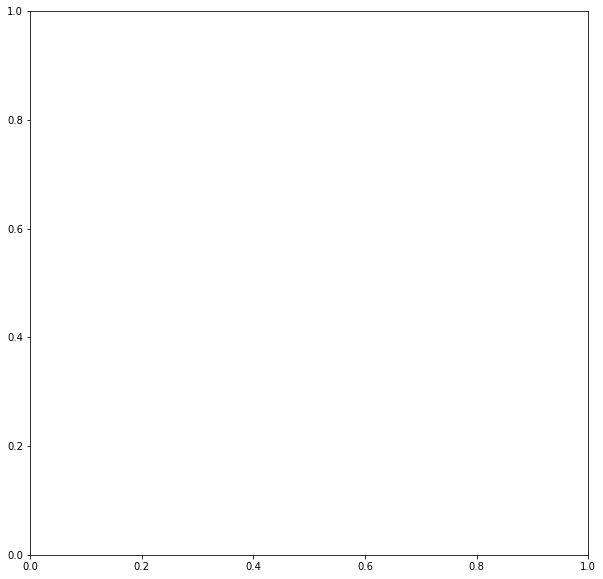

In [13]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred_new_threshold,
                                 cmap=plt.cm.Greens,
                                 normalize=normalize,
                                 ax = ax)
    ax.set_title(title)